# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions


In [1]:
#!pip install --upgrade GPy
#!pip install --upgrade numpy

In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GPy
import numpy as np

from datetime import datetime
from glob import glob
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm, percentileofscore

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


# <a name="loading_datasets"></a> 2. Loading Datasets


## Load metadata


In [3]:
metdata_path = "..\\data\\metadata\\"
metadata = pd.read_csv(metdata_path + "metadata.csv")


## Load weather data

In [4]:
# Weather data
weather_path = "..\\data\\weather\\"
weather = pd.read_csv(weather_path + "weather.csv")

In [5]:
# Convert timestamp field from string into pd.datetime object
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
weather['date'] = weather['timestamp'].dt.date
weather['month'] = weather['timestamp'].dt.month

In [6]:
weather.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed,date,month
0,2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0,2016-01-01,1
1,2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0,2016-01-01,1
2,2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5,2016-01-01,1
3,2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0,2016-01-01,1
4,2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5,2016-01-01,1



## Load raw dataset

In [7]:
raw_meters_path = "..\\data\\meters\\raw\\"

# files in directory
files = glob(raw_meters_path + "*.csv")

In [8]:

dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
raw_data = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

raw_data.head()


,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater


## Load cleaned dataset


In [9]:
cleaned_meters_path = "..\\data\\meters\\cleaned\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


In [10]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

complete_data_cleaned.head()


,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned


In [11]:
# Note this cell might take some time to finish

# Convert timestamp field from string into pd.datetime object
complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
complete_data_cleaned['date'] = complete_data_cleaned['timestamp'].dt.date
complete_data_cleaned['year'] = complete_data_cleaned['timestamp'].dt.year
complete_data_cleaned['month'] = complete_data_cleaned['timestamp'].dt.month
complete_data_cleaned['dayOfWeek'] = complete_data_cleaned['timestamp'].dt.dayofweek


In [12]:
meter_types = complete_data_cleaned['meter'].unique()
other_meter_types = meter_types.tolist().remove('electricity_cleaned')

# Load benchmarks


In [13]:
cleaned_meters_path = "..\\data\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


benchmark = pd.read_csv(files[0]) # load the dataset

benchmark

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


In [14]:
buildingNames = benchmark['name'].unique()

# Specify Constants

In [215]:
# We load the first 
building_name = buildingNames[0]
representative_df = complete_data_cleaned.loc[(complete_data_cleaned['building_id'] == building_name)
                                               & (complete_data_cleaned['meter'] == 'electricity_cleaned')]

In [230]:
TRAIN_TEST_SPLIT = 0.3
DATAPOINS_PER_BUILDING_AND_METER_TYPE = representative_df.shape[0]
SPLIT_INDEX = int(DATAPOINS_PER_BUILDING_AND_METER_TYPE * (1 - TRAIN_TEST_SPLIT))
SPLIT_TIMESTAMP =  representative_df.iloc[SPLIT_INDEX]['timestamp']
TRAIN_DIMENSIONS = 5
SAMPLE_SIZE = 2000

# Gaussian Process Regression

## Helper Functions

In [16]:
"""
Normalizes the data to a Gaussian distribution using quantiles.
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [17]:
'''
Function that transforms the Gaussian normalisation back to percentiles of scores
'''
def gaussianToCdf(arr):
    n = len(arr)
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.cdf(arr[i])
        else:
            out[i] = np.nan
            
    out = out
    
    return out

In [18]:
def transformIntoOriginalRange(arr, original):

    
    original_min = np.min(original)
    original_max = np.max(original)
    original_mean = np.nanmean(original) 
    original_std = np.nanstd(original)

    # Calculate the range, mean, and standard deviation of the predictions
    arr_range = np.max(arr) - np.min(arr)
    arr_mean = np.mean(arr)
    arr_std = np.std(arr)

    # Rescale the predictions based on the original signal's range and statistics
    rescaled = (
        (arr - arr_mean) * (original_std / arr_std) + original_mean
    )

    # Adjust the rescaled predictions to fit within the original signal's range
    min_diff = original_min - np.min(rescaled)
    max_diff = np.max(rescaled) - original_max
    if min_diff > 0:
        rescaled -= min_diff
    elif max_diff > 0:
        rescaled -= max_diff
 
    return rescaled

In [19]:
'''
Replaces missing values in the dataframe with the mean of the month for all years from which we have data
@param dataframe
@returns numpy array
'''
def averageNaNs (df, field):
    mean_df = df.groupby(['month']).mean()
    averaged_mean = df[field].copy().fillna(df['month'].map({1: mean_df[field][1] , 2: mean_df[field][2], 3:mean_df[field][3],
                                                    4: mean_df[field][4] , 5: mean_df[field][5], 6:mean_df[field][6], 
                                                    7: mean_df[field][7] , 8: mean_df[field][8], 9:mean_df[field][9],
                                                    10: mean_df[field][10] , 11: mean_df[field][11], 12:mean_df[field][12]}))
    
    averaged_numpy = averaged_mean.to_numpy()
    return averaged_numpy

In [20]:
'''
Train a Gaussian Process model based on the training data
@param two numpy arrays of same dimensionality
@returns numpy array with lenght NUMBER_OF_DIMENSIONS, containing the indices of the most correlated stations
'''
def trainGP (X_train, Y_train):
    
    # Shape of training data needs to be consistent 
    assert X_train.shape[0] == Y_train.shape[0]
    
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1])
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize(messages=True)
    model.optimize_restarts(num_restarts=10)
    
    return model

# So far unused helper functions

In [21]:
'''
Computation of Spearmas Rank Correlation
@param  target_df: a pandas.dataframe (target) for wich we want to calculate the correlation matrix 
        dataset: a list of pandas dataframes that build our base, as we check for the correlation between dataframe and each df in the truncated dataset
@returns spearmans_matrix: a numpy.ndarray that contains the correlation value as first entry in each row and the corresponding p-value as a second element in each row. 
                            the order of stations in the matrix is consistent to the order in the dataset:
'''
def spearmansCorrelation (target, possible_features): 
    spearmans_matrix = np.zeros((len(possible_features), 2))
    for index, feature in enumerate(possible_features): 
        if target.shape[0] == feature.shape[0]:
            correlation, pval = stats.spearmanr(target['meter_reading'], feature['meter_reading'], nan_policy='omit')
            spearmans_matrix[index] = correlation,pval    

        else: 
            spearmans_matrix[index] = 0,100 
            continue
            
    return spearmans_matrix

### Load dataframe

In [22]:
# Find the dataframe that matches our building_id
bear_sidney = complete_data_cleaned.loc[complete_data_cleaned['building_id']  == 'Bear_utility_Sidney']

# For later reconstruction we split the original meter reading into train and test
original_data_train, original_data_test = train_test_split(bear_sidney['meter_reading'], test_size=0.3, shuffle=False)

# Load the meta data for the given building_id
bear_sidney_meta = metadata.loc[metadata['building_id'] == 'Bear_utility_Sidney']

# load the weather data for the location 
bear_weather = weather.loc[weather['site_id'] == 'Bear']

In [188]:
original_data_train.tail()

21573851    62.7850
21573852    61.9200
21573853    61.1675
21573854    57.9525
21573855    54.1050
Name: meter_reading, dtype: float64

### Transform into Gaussian

In [23]:
bear_sidney_gauss = normalizeToGaussian(averageNaNs(bear_sidney, 'meter_reading'))

In [24]:
bear_sidney_weather_air_temp = normalizeToGaussian(averageNaNs(bear_weather,'airTemperature'))
bear_sidney_weather_dew_temp = normalizeToGaussian(averageNaNs(bear_weather,'dewTemperature'))
bear_sidney_weather_precip_1HR = normalizeToGaussian(averageNaNs(bear_weather,'precipDepth1HR'))

### Split into train and test sets

In [25]:
train_meter, test_meter = train_test_split(bear_sidney_gauss, test_size=0.300, shuffle=False)
train_weather_air_temp, test_weather_air_temp = train_test_split(bear_sidney_weather_air_temp, test_size=0.300, shuffle=False)
train_weather_dew_temp, test_weather_dew_temp = train_test_split(bear_sidney_weather_dew_temp, test_size=0.300, shuffle=False)
train_weather_precip_1HR, test_weather_precip_1HR = train_test_split(bear_sidney_weather_precip_1HR, test_size=0.300, shuffle=False)

In [26]:
spMatrix = spearmansCorrelation(train_meter, [train_weather_air_temp, train_weather_dew_temp, train_weather_precip_1HR])

In [28]:
X_train = np.column_stack(([train_weather_air_temp, train_weather_dew_temp, train_weather_precip_1HR]))
X_test = np.column_stack(([test_weather_air_temp, test_weather_dew_temp, test_weather_precip_1HR]))

## Specify and Train Gaussian Process model

In [29]:
# Specify the kernel: Radial basis function kernel (RBF)
kernel = GPy.kern.RBF(input_dim=X_train.shape[1])  

# Create a GP Regression model
model = GPy.models.GPRegression(X_train[-3000:], train_meter[-3000:].reshape(-1,1), kernel)

# Optimize model parameters
model.optimize(messages=True)

In [30]:
# Make predictions with the trained model
mean, var = model.predict(X_test[0:200])

###### Plot the results given driectly from the GP

Note as we previously transformed the data to be normal distributed, the data we obtain here is as well transformed <br>
In order to reconstruct the original data we need to transform it back

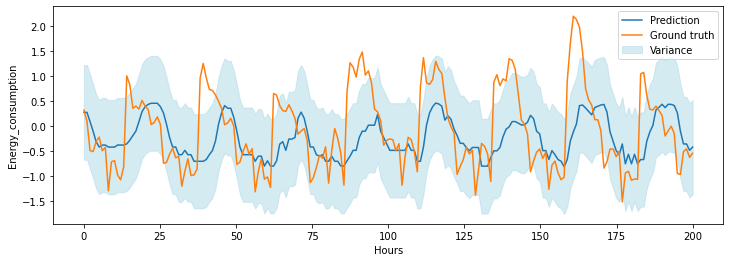

In [31]:
x = np.linspace(0, np.size(mean), np.size(mean))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(x, mean, label='Prediction')
plt.plot(x, test_meter[0:200], label='Ground truth')
plt.fill_between(x, (mean - var).flatten(), (mean + var).flatten(), color='lightblue', alpha=0.5, label='Variance')
plt.legend()
plt.show()

## Convert the results back and compare them

In [32]:
prediction_transformed = transformIntoOriginalRange(mean.flatten(), original_data_train)
variance_transformed = transformIntoOriginalRange(var.flatten(), original_data_train)
original_test_transformed = transformIntoOriginalRange(original_data_test[0:200], original_data_train)

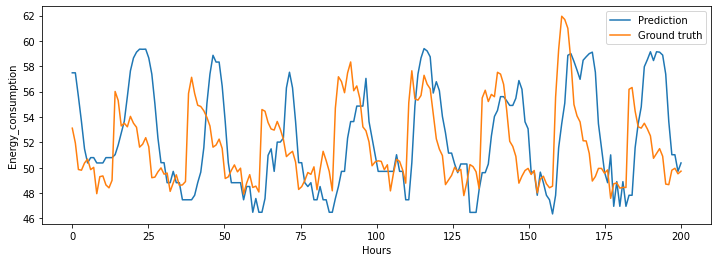

In [33]:
x = np.linspace(0, np.size(prediction_transformed), np.size(prediction_transformed))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(x, prediction_transformed, label='Prediction')
plt.plot(x, original_data_test[0:200], label='Ground truth')
plt.legend()
plt.show()

# Error computation

In [34]:
mse = mean_squared_error(original_data_test[0:200], prediction_transformed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(original_data_test[0:200], prediction_transformed)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE", mae)

MSE:  17.431229363926832
RMSE:  4.175072378286014
MAE 3.214666504598467


## Iteration over all buildings we want to predict

In [35]:
'''
For our given dataset we 
'''
def getDfsOfOtherMeterTypes(df): 
    dfs_meter_types = []
    meter_types = df['meter'].unique()

    for meterType in meter_types:
        if meterType == 'electricity_cleaned':
            continue
        
        dfs_meter_types.append(df.loc[df['meter'] == meterType]) 
        
    return dfs_meter_types

In [36]:
building_ids = complete_data_cleaned['building_id'].unique()
meter_types = complete_data_cleaned['meter'].unique()

In [37]:
# function not needed

def getAllMeterDfsExceptTarget(building_id): 
    dfs = []
    for id in building_ids:
        print(building_id)
        building = complete_data_cleaned.loc[complete_data_cleaned['building_id'] == id]
        for meter_type in building['meter'].unique(): 
            # We do not want to contain our target into this list of dataframes
            if ((id == building_id) and (meter_type == 'electricity_cleaned')):
                continue
            
            building_meter = building.loc[building['meter'] == meter_type]
            dfs.append(building_meter) 
        
    return dfs

In [38]:
# Group the DataFrame by 'building_id' and 'meter_type'
complete_data_grouped = complete_data_cleaned.groupby(['building_id', 'meter'])

# Initialize an empty list to store the smaller DataFrames
dfs = []
df_keys = []

# Iterate over the groups and create smaller DataFrames
for group_key, group in complete_data_grouped:
    df_keys.append(group_key)
    dfs.append(group.copy()) 

In [39]:
numpy_keys = np.array(df_keys)

In [226]:
def get_all_features(dataset, building_name):
    key_to_exclude = [building_name, 'electricity_cleaned']
    features = []
    index_of_df = np.nan
    for index, key in enumerate(numpy_keys):
        # as the key composes of two elements, the buildling_id and the meter_type we compare two arrays of strings, therefore we need the .all() 
        if(key == key_to_exclude).all():
            index_of_df = index
            continue
        features.append(dataset[index])
            
    return features, index_of_df

In [41]:
def get_start_and_end_timestamp(df):
    return df['timestamp'].iloc[0], df['timestamp'].iloc[-1]

In [42]:
#! DEPRECATED!_
def truncate_to_time_range(df,start, end):
    return df.loc[(df['timestamp'] >= start) & (df['timestamp'] <= end)].reset_index(drop=True) 

In [229]:
def split_df_to_train_and_test(df, split_date):
    df_train = df.loc[df['timestamp'] < split_date].copy().reset_index(drop=True) 
    df_test  = df.loc[df['timestamp'] >= split_date].copy().reset_index(drop=True)
    return df_train, df_test

In [225]:
dfs_train = []
dfs_test = []

for df in dfs: 
    temp_train_df, temp_test_df = split_df_to_train_and_test(df, SPLIT_TIMESTAMP)
    dfs_train.append(temp_train_df)
    dfs_test.append(temp_test_df)

In [44]:
features, ind = get_all_features('Bear_education_Alvaro')

In [119]:
spMatrix = spearmansCorrelation(dfs[ind], features)

 C:\Users\marku\anaconda3\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning:An input array is constant; the correlation coefficient is not defined.
 C:\Users\marku\anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:517: RuntimeWarning:invalid value encountered in true_divide


In [135]:
matrix = spMatrix.copy()

In [161]:
def sort_according_to_highest_correlation(spearmans_matrix):
    correlation_values = spearmans_matrix[:,0]
    clean_correlation_values = np.nan_to_num(correlation_values, 0)
    clean_abs_correlation_values = np.abs(clean_correlation_values)
    sorted_indices = np.argsort(clean_abs_correlation_values)[::-1]
    
    return sorted_indices

In [162]:
sorted_indices = get_indices_of_highest_correlated_dfs(matrix)

In [227]:
dfs_as_features = []
for ind in sorted_indices[0:10]:
    dfs_as_features.append(features[ind])

In [237]:
def transform_highest_correlated_dfs_to_training_data(list_of_dfs,indices):
    transformed_features = []
    for ind in sorted_indices[:TRAIN_DIMENSIONS]:
        temp_df = list_of_dfs[ind]
        avg_temp_df = averageNaNs(df, 'meter_reading')
        transformed_features.append(normalizeToGaussian(avg_temp_df))
    
    return np.column_stack((transformed_features))

        

In [ ]:
def random_sampling(X_train, y_train, num_samples=SAMPLE_SIZE, random_seed=42):
    np.random.seed(random_seed)

    indices = np.random.choice(len(X_train), size=num_samples, replace=False)
    X_samples = X_train[indices]
    y_samples = y_train[indices]

    return X_samples, y_samples

In [ ]:
for name in buildingNames[0:1]: 
    print(name)
    
    # Get dataframe that matches our building_id
    df = complete_data_cleaned.loc[complete_data_cleaned['building_id']  == name]
    
    # For later reconstruction we split the electricity meter reading into train and test set
    y_train_df, y_test_df = split_df_to_train_and_test(df, SPLIT_TIMESTAMP)
    
    print("loading all other features ...")
    # Load all other features like water consumption, gas ....
    features_train, own_index = get_all_features(dfs_train, name)

    print("all other features loaded")
    
    # OPTIONAL
    # 1. Load the weather data for the location
    #siteName = name.split('_')[0]
    #weather = weather.loc[weather['site_id'] == siteName]
    # 2. Load the water data
    
    print("compute spearmans matrix ...")
    # Compute the spearmans correlation between all those features in order to pick the most relevant ones
    spearmans_matrix = spearmansCorrelation(y_train_df, features_train)
    print("spearmans matrix comptued", spearmans_matrix)

    
    # Sort according to highest correlation
    sorted_indices = sort_according_to_highest_correlation(spearmans_matrix)
    print("sorted indices: ", sorted_indices)
    
    
    prin("transforming highest correlated dfs")
    # Bring data into format to fit as GP Regression input (normal distribution)
    X_train = transform_highest_correlated_dfs_to_training_data(dfs_train, sorted_indices)
    X_test = transform_highest_correlated_dfs_to_training_data(dfs_test)

    print("X_train.shape", X_train.shape)
    print("X_test.shape", X_test.shape)
    
    
    Y_train = normalizeToGaussian(averageNaNs(y_train_df, 'meter_reading'))
    Y_test = normalizeToGaussian(averageNaNs(y_test_df, 'meter_reading'))
    
    
    print("Y_train.shape", Y_train.shape)
    print("Y_test.shape", Y_test.shape)
    
    sampled_X_train, sampled_Y_train = random_sampling(X_train, Y_train)
    
    print("sampled_X_train.shape", sampled_X_train.shape)
    print("sampled_Y_train.shape", sampled_Y_train.shape)
        
    # Randomly sample from the datapoints, as we cannot train on the whole dimensions
    
    print("Training model ....")
    # Train the model 
    model = trainGP (sampled_X_train, sampled_Y_train)
    
    print("predicting ...")
    # Make predictions with the trained model for one week
    mean, var = model.predict(X_test[0:200])
    
    #Compute the error values for each timesoan hour, day, week
    

Bear_utility_Sidney
loading all other features ...
all other features loaded
compute spearmans matrix ...
